# Autonomous Vehicle Scenerios Toy Model

In [1]:
import pennylane as qml
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

import math
import random
import matplotlib.pyplot as plt

random.seed(10)

<img src="graphics/car_difficulty_reps.png" width="500" />

In [2]:
# Create an empty road
def create_road():
    return np.array([[1.,1.,1.],[1.,1.,1.],[1.,1.,1.]])

# Create car in straight road scenerio with difficulty(y)
def straight_road_with_car(road):
    straight_road = []
    y = 0.
    for i, j, k in [[0,1,2],[0,2,1],[1,2,0]]:
        road = create_road()
        road[i] = np.array([-1.,-1.,-1.])
        road[j] = np.array([-1.,-1.,-1.])
        road[k] = np.array([-0.33333,0.33333,1.])
        straight_road.append([road.flatten(), y])

    for i, j, k in [[0,1,2],[0,2,1],[1,2,0]]:
        road = create_road()
        road[i] = np.array([-1.,-1.,-1.])
        road[j] = np.array([-1.,-1.,-1.])
        road[k] = np.array([1.,0.33333,-0.33333])
        straight_road.append([road.flatten(), y])
        
        
    return straight_road


In [3]:
# Create corner road scenerio
def corner_road(road):
    corner_road = []
    for index in [[0,1,3,4],[1,2,4,5],[3,4,6,7],[4,5,7,8]]:
        road = create_road().flatten()
        for j in index:
            road[j] = -1.
        corner_road.append(road)
    
    return corner_road

# Create scenerio with car turning left on a corner with difficulty
def corner_road_with_left_turn(road):
    road = corner_road(road)
    corner = [[7,8],[3,6],[5,2],[1,0]]
    y = 0.2
   
    for i,j in enumerate(corner):
        road[i][j[0]] = -0.33333
        road[i][j[1]] = 0.33333
    
    road_with_difficulty = [[road[i],y] for i in range(len(road))]

    return road_with_difficulty

# Create scenerio with car turning right on a corner with difficulty
def corner_road_with_right_turn(road):
    road = corner_road(road)
    corner = [[5,8],[7,6],[1,2],[3,1]]
    y = 0.2 
    
    for i,j in enumerate(corner):
        road[i][j[0]] = -0.33333
        road[i][j[1]] = 0.33333

    road_with_difficulty = [[road[i],y] for i in range(len(road))]

    return road_with_difficulty

In [4]:
# Create T-crossing road
def t_crossing_road(road):
    t_crossing_road = []
    for index in [[0,3,2,5],[3,6,5,8],[0,1,6,7],[1,2,7,8]]:
        road = create_road().flatten()
        for j in index:
            road[j] = -1
        t_crossing_road.append(road)
    return t_crossing_road

# Create scenerio with car turning straight or right on a t-crossing with difficulty
def t_crossing_straight_right(road):
    road = t_crossing_road(road)
    t_crossing = [[8,7],[0,1],[2,5],[6,3]]
    y = 0.4

    for i,j in enumerate(t_crossing):
        road[i][j[0]] = -0.33333
        road[i][j[1]] = 0.33333

    road_with_difficulty = [[road[i],y] for i in range(len(road))]

    return road_with_difficulty

# Create scenerio with car turning straight or left on a t-crossing with difficulty
def t_crossing_straight_left(road):
    road = t_crossing_road(road)
    t_crossing = [[6,7],[2,1],[8,5],[0,3]]
    y = 0.6

    for i,j in enumerate(t_crossing):
        road[i][j[0]] = -0.33333
        road[i][j[1]] = 0.33333
    
    road_with_difficulty = [[road[i],y] for i in range(len(road))]
    
    return road_with_difficulty

# Create scenerio with car turning right or left on a t-crossing with difficulty
def t_crossing_right_left(road):
    road = t_crossing_road(road)
    t_crossing = [[4,7],[4,1],[4,5],[4,3]]
    y = 0.8

    for i,j in enumerate(t_crossing):
        road[i][j[0]] = -0.33333
        road[i][j[1]] = 0.33333
    
    road_with_difficulty = [[road[i],y] for i in range(len(road))]
    
    return road_with_difficulty

In [5]:
# Create intersection road
def intersection_road(road):
    road = create_road().flatten()
    for i in [0,2,6,8]:
        road[i] = -1
    return road

# Create scenerio with car in an intersection with difficulty
def intersection_with_car(road):
    intersection = [[1,4],[7,4],[3,4],[5,4]]
    intersection_scenerio = []
    y = 1.0

    for i in intersection:
        road = intersection_road(road)
        road[i[0]] = -0.33333
        road[i[1]] = 0.33333
        intersection_scenerio.append([road,y])
    return intersection_scenerio


Since there are 6 scenerios in straight road, 8 scenerios in corner road, 12 scenerios in t-crossing and 4 scenerios in intersection, we have to adjust in order to ensure equal probability of of each scenerio.

In [6]:
def random_road():

    road_function = [straight_road_with_car, corner_road_with_left_turn, corner_road_with_right_turn, 
                    t_crossing_straight_right, t_crossing_right_left, t_crossing_right_left,
                    intersection_with_car,
                    straight_road_with_car, corner_road_with_left_turn,
                    intersection_with_car,intersection_with_car]
    
    road = create_road()
    road = random.choice(road_function)(road)
    rnd = random.randrange(len(road))

    return road[rnd]

random_road()

[array([-1.     , -0.33333, -1.     ,  1.     ,  0.33333,  1.     ,
        -1.     ,  1.     , -1.     ]),
 1.0]

In [7]:
# Create a dictionary to store the data of each training
def create_road_dataset(size_of_each_scenerio):
    road_scenerio = {0.0:[], 0.2:[], 0.4:[], 0.6:[], 0.8:[], 1.0:[]}
    
    
    while np.max([len(scenerio_size) for _,scenerio_size in road_scenerio.items()]) < size_of_each_scenerio:
        road = random_road()[0]
        difficulty = random_road()[1]
        road_scenerio[difficulty].append(road)

    # Convert dictionary to list
    road_result = []
    for difficulty,roads in road_scenerio.items():
        road_result += [(road,difficulty) for road in roads]

    return road_result


The symmetry of our toy model is similar to the $D_4$ symmetry of the tic tac toe game we considered above. The only difference lies in the absenece of reflection ($b$).For example, in the right-turn corner scenerio, if we reflect the road around the vertical axis through the center, it will become a left-turn corner scenerio.

<img src="graphics/road_symm.png" width="200" />

 If we use the same notation as above, we are left with generator $a$ only, where $a$ generates $\frac{\pi}{2}$ anti-clockwise rotation. Therefore, the toy model follows a $\mathbb{Z}_4$ symmetry.The 4 elements of the $\mathbb{Z}_4$ group are $\{\mathbb{1},a,a^2,a^3\}$. Follwoing our indexing scheme, the 4 elements of the $\mathbb{Z}_4$ group are expressed as the following permutations,


\begin{equation*}
\begin{split}
\mathbf{1}\ \ \ &\to \mathbf{1}\\
a\ \ \ &\to (0286)(1573)\\
a^2\ \ \ &\to (08)(26)(17)(35)\\
a^3\ \ \ &\to (0682)(1357).\\
\end{split}
\end{equation*}

The missing mirror symmetry splits the outer layer into two subgoups, one with clockwise controlled operations between the edges and corners and the other one with anti-clockwise of the same operations. Since each subgroup has one parameter, we have 9 parameters for this circuit instead of 8 comparing to the tic-tac-toe case.



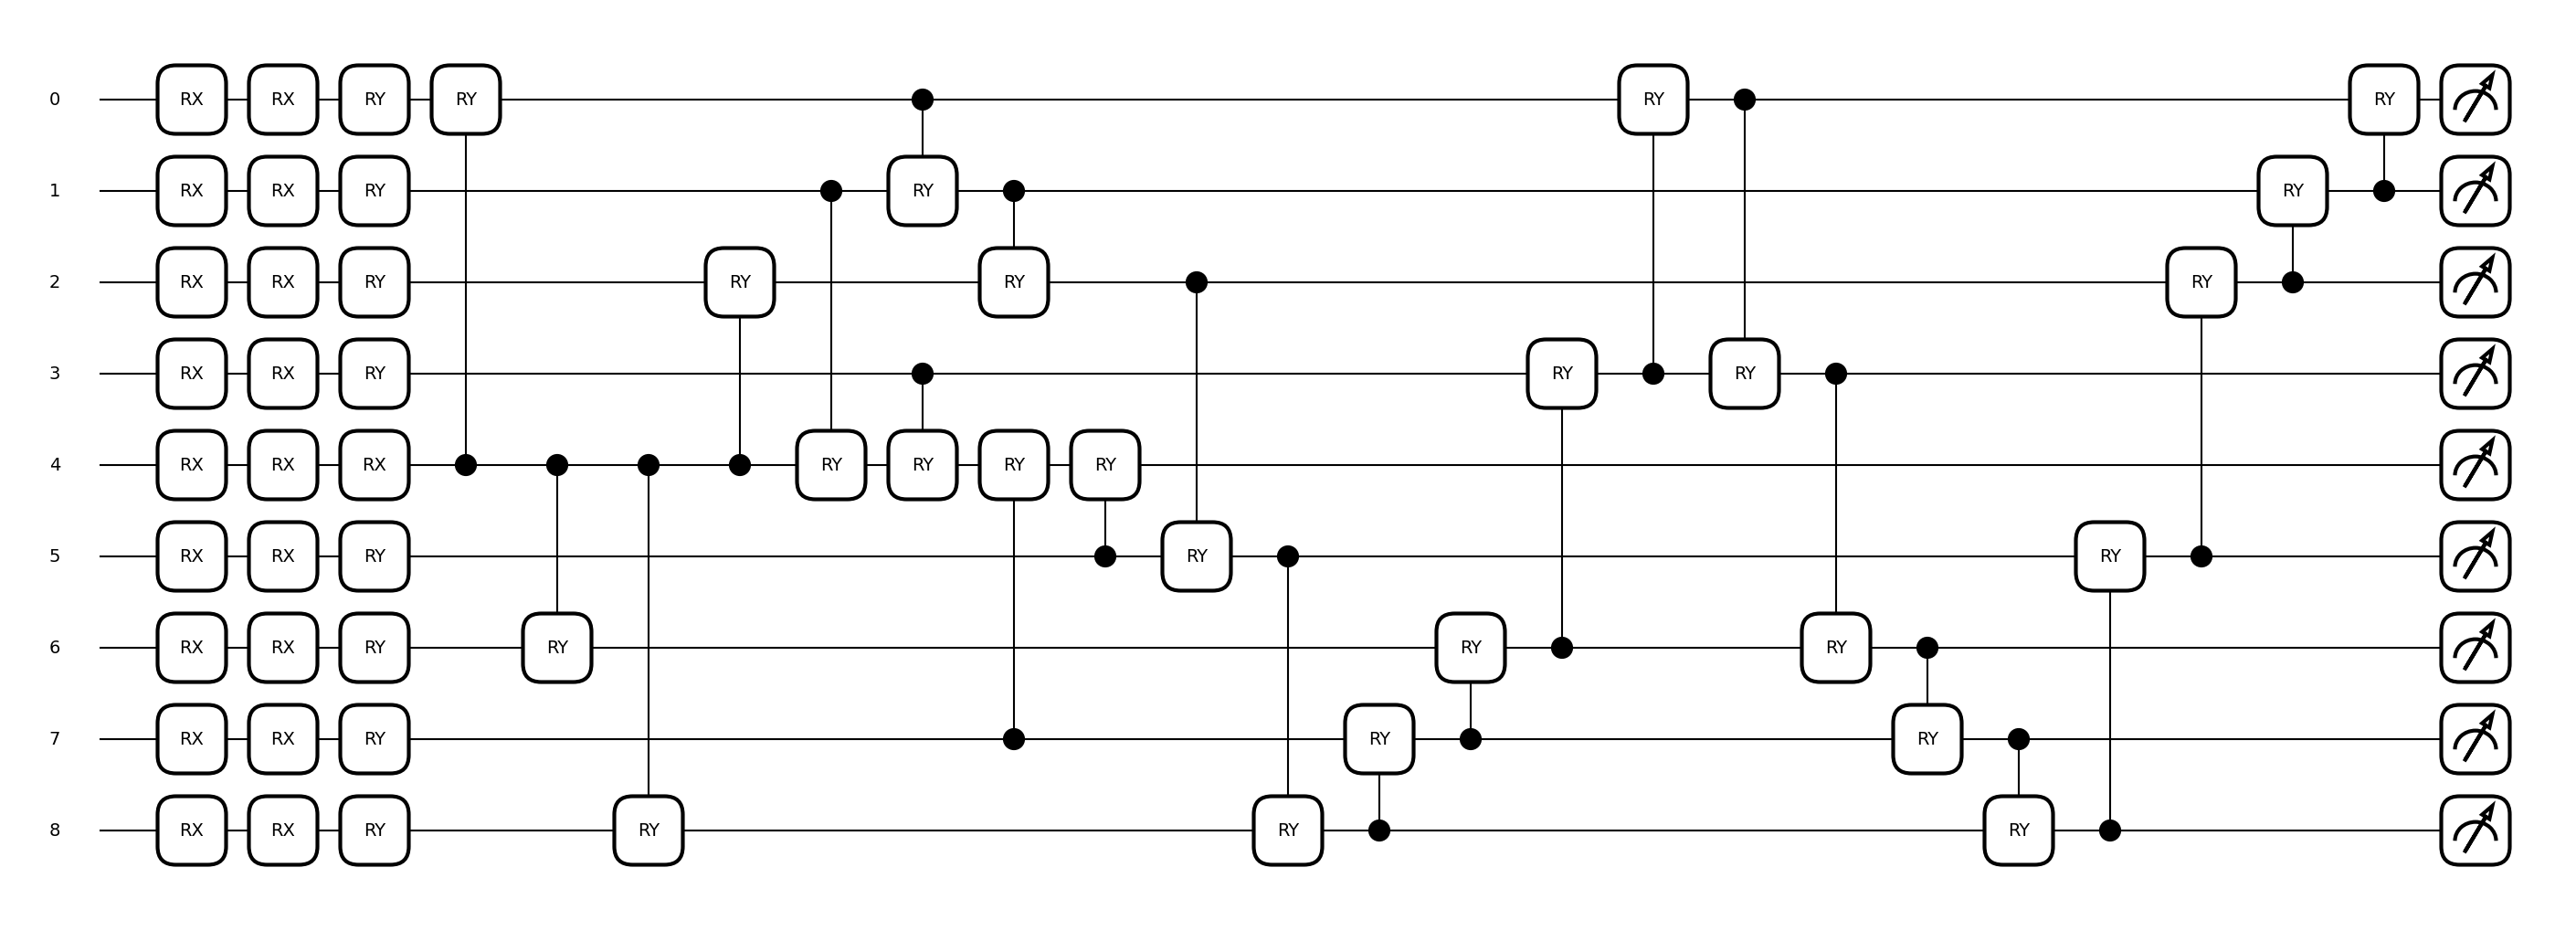

In [8]:
dev = qml.device('default.qubit', wires = 9)

center = (qml.PauliZ(4)+1)*(1/2)
corners = (qml.PauliZ(0) + qml.PauliZ(6) + qml.PauliZ(8)  + qml.PauliZ(2)) * (1/4)
edges =  (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(7)  + qml.PauliZ(5)) * (1/4)

corner_qubits = [0,6,8,2]
edge_qubits = [1,3,7,5]

@qml.qnode(dev, interface='tf')
def road_circuit_with_symm(x,p):
    # Initialize the qubits (will be discussed later)
    for i in range(9):
        qml.RX(x[i], wires=i)

################### One-qubit gates  #############################

    # Centre single qubit rotation
    qml.RX(p[0], wires= 4)
    qml.RX(p[1], wires= 4)

    # Corner single qubit rotation
    for i in corner_qubits:
        qml.RX(p[2], wires = i)

    for i in corner_qubits:
        qml.RY(p[3], wires = i)

    # Edge single qubit rotation
    for i in edge_qubits:
        qml.RX(p[4], wires = i)

    for i in edge_qubits:
        qml.RY(p[5], wires = i)

####################### Two-qubits gates #######################

    # Edges between middle and corners rotation
    for i in corner_qubits:
        qml.CRY(p[6], wires = [4,i])


    # Edges between edges and middle rotation
    for i in edge_qubits:
        qml.CRY(p[7], wires = [i,4])


    # Edges between corners and edges rotation (clockwise)
    clockwise_outer_qubit = [0,1,2,5,8,7,6,3]

    for index, qubit in enumerate(clockwise_outer_qubit):
        if index != len(clockwise_outer_qubit)-1:
            qml.CRY(p[8], [qubit,clockwise_outer_qubit[index+1]])
        
        else:
            qml.CRY(p[8],[qubit,clockwise_outer_qubit[0]])


    # Edges between corners and edges rotation (anti-clockwise)
    anticlockwise_outer_qubit = [0,3,6,7,8,5,2,1]

    for index, qubit in enumerate(anticlockwise_outer_qubit):
        if index != len(anticlockwise_outer_qubit)-1:
            qml.CRY(p[9], [qubit,anticlockwise_outer_qubit[index+1]])
        
        else:
            qml.CRY(p[9],[qubit,anticlockwise_outer_qubit[0]])


    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

fig, ax = qml.draw_mpl(road_circuit_with_symm)([0]*9,[i for i in range(18)])

In this toy model, the unsymmetrized version requires 42 parameters.

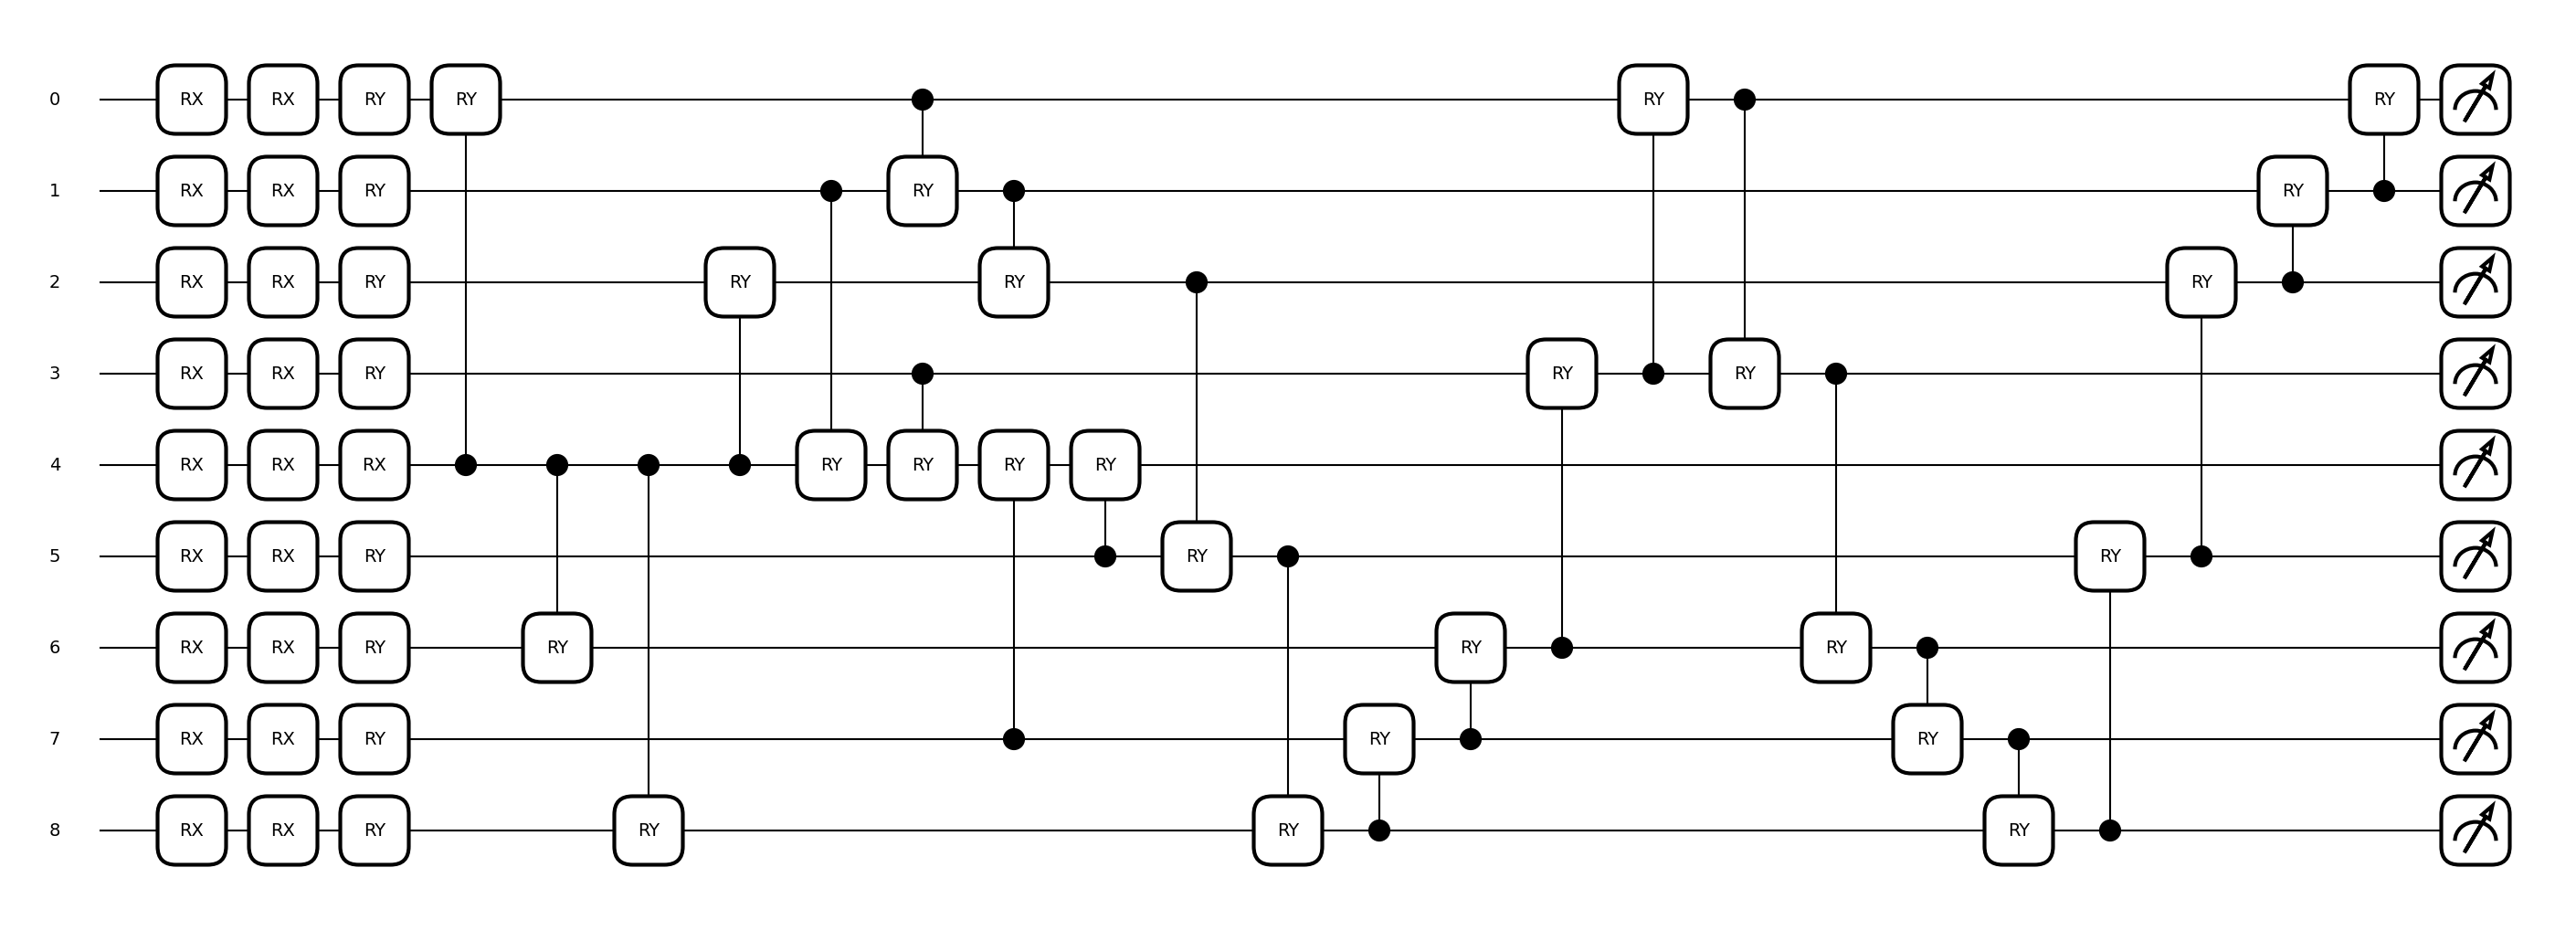

In [9]:
dev = qml.device('default.qubit', wires = 9)


corner_qubits = [0,6,8,2]
edge_qubits = [1,3,7,5]
l = len(corner_qubits)

@qml.qnode(dev, interface='tf')
def road_circuit_without_symm(x,p):
    # Initialize the qubits (will be discussed later)
    for i in range(9):
        qml.RX(x[i], wires=i)

################### One-qubit gates  #############################

    # Centre single qubit rotation
    qml.RX(p[0], wires= 4)
    qml.RX(p[1], wires= 4)

    # Corner single qubit rotation
    for i,j in zip(corner_qubits, range(2,2+l)):
        qml.RX(p[j], wires = i)

    for i,j in zip(corner_qubits, range(2+l,2+2*l)):
        qml.RY(p[j], wires = i)

    # Edge single qubit rotation
    for i,j in zip(edge_qubits, range(2+2*l,2+3*l)):
        qml.RX(p[j], wires = i)

    for i,j in zip(edge_qubits, range(2+3*l,2+4*l)):
        qml.RY(p[j], wires = i)

####################### Two-qubits gates #######################

    # Edges between middle and corners rotation
    for i,j in zip(corner_qubits, range(2+4*l,2+5*l)):
        qml.CRY(p[j], wires = [4,i])


    # Edges between edges and middle rotation
    for i,j in zip(edge_qubits, range(2+5*l,2+6*l)):
        qml.CRY(p[j], wires = [i,4])


    # Edges between corners and edges rotation (clockwise)
    clockwise_outer_qubit = [0,1,2,5,8,7,6,3]

    for index, qubit in enumerate(clockwise_outer_qubit):
        if index != len(clockwise_outer_qubit)-1:
            qml.CRY(p[2+6*l+index], [qubit,clockwise_outer_qubit[index+1]])
            
        else:
            qml.CRY(p[34],[qubit,clockwise_outer_qubit[0]])


    # Edges between corners and edges rotation (anti-clockwise)
    anticlockwise_outer_qubit = [0,3,6,7,8,5,2,1]

    for index, qubit in enumerate(anticlockwise_outer_qubit):
        if index != len(anticlockwise_outer_qubit)-1:
            qml.CRY(p[35+index], [qubit,anticlockwise_outer_qubit[index+1]])
        
        else:
            qml.CRY(p[42],[qubit,anticlockwise_outer_qubit[0]])



    return [qml.expval(qml.PauliZ(i)) for i in range(9)]

fig, ax = qml.draw_mpl(road_circuit_with_symm)([0]*9,[0]*42)

In [10]:
road_params = tf.Variable(0.01 * np.random.randn(10))
road_params_wtihout_symm = tf.Variable(0.01 * np.random.randn(43))


# Prepare training and validation datasets
training_size =8
road_training_dataset = create_road_dataset(training_size)


len(road_training_dataset)


21

In [11]:
road_training_dataset = list(zip(*[road for road in road_training_dataset]))

road_x_dataset = np.stack(road_training_dataset[0])
road_y_dataset = np.stack(road_training_dataset[1])


road_x_train, road_x_test, road_y_train, road_y_test = train_test_split(
    road_x_dataset, road_y_dataset, test_size=0.3, random_state=42)


road_symmetrized_x_dataset = np.array([road_circuit_with_symm(x, road_params) for x in road_x_dataset])
road_unsymmetrized_x_dataset = np.array([road_circuit_without_symm(
    x, road_params_wtihout_symm) for x in road_x_dataset])


### Method 1
We follow the paper [1], where it suggests the following loss function,
\begin{equation*}
\hat{y} = \frac{Z_{middle}+1}{2}.
\end{equation*}

[1] 'Exploiting symmetry in variational quantum machine learning', 2022, arXiv:2205.06217v1

In [12]:
def road_optimize_circuit(x_data,y_data,params):

    weights = tf.Variable(params)
    opt = tf.keras.optimizers.RMSprop(learning_rate=1e-1)
    outcome = [0.0,0.2,0.4,0.6,0.8,1.0]
    steps = 10

    losses = []
    losses_mean_list = []
    
    for _ in range(steps):
        with tf.GradientTape() as tape:
            for i in range(len(x_data)):
                result = road_circuit_with_symm(x_data[i],weights)


                center = (result[4] + 1.) * 0.5
                
                index = outcome - center
                #print((center,index))
                close_index = [outcome[np.abs(index).argmin()]]
                diff = center - close_index
                y_hat = center + diff

                loss = tf.math.subtract(y_data[i],y_hat)
                loss = tf.math.multiply(loss,loss)
                losses.append(loss)

            losses_mean = tf.math.reduce_mean(losses)

        losses_mean_list.append(losses_mean)
        
       
        grad = tape.gradient(losses_mean, [weights])
        print(grad)

        opt.apply_gradients(zip(grad, [weights]))

    print(weights)
    return losses_mean_list

In [13]:
print(road_params)
road_train_loss = road_optimize_circuit(road_x_train,road_y_train,road_params)

<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 5.15615796e-03, -2.28826757e-03,  2.42608898e-02, -1.66303951e-03,
       -1.81957551e-02, -3.40331825e-03,  4.80686193e-05,  1.26862815e-03,
        2.60167421e-03,  1.02212487e-02])>
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 2.17692136e-01,  2.17692136e-01,  1.13070215e-08, -3.54483288e-19,
        1.09113758e-07,  3.61711173e-09,  2.03979092e-04, -6.52744489e-04,
        2.91167576e-20, -3.28331146e-19])>]
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 1.35330793e-01,  1.35330793e-01, -1.22179091e-03,  6.50097787e-20,
        4.32313518e-05,  1.80007651e-05,  6.73427845e-04, -2.35608225e-02,
       -5.83327768e-21, -1.16387621e-19])>]
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 5.18120259e-02,  5.18120259e-02, -5.83134794e-03, -4.89367991e-18,
        1.37945095e-03,  1.25061958e-04, -6.97835761e-03, -2.35050340e-02,
       -3.06431539e-19, -2.80262026e-19])>]
[<tf.Tensor: shape=(1

In [14]:
print(road_params)
road_test_loss = road_optimize_circuit(road_x_test,road_y_test,road_params)

<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([ 5.15615796e-03, -2.28826757e-03,  2.42608898e-02, -1.66303951e-03,
       -1.81957551e-02, -3.40331825e-03,  4.80686193e-05,  1.26862815e-03,
        2.60167421e-03,  1.02212487e-02])>
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-7.70622368e-02, -7.70622368e-02, -3.60578107e-09,  1.45689667e-19,
       -6.28123164e-08,  4.08735353e-09,  2.52783587e-04, -7.46976602e-04,
        6.41627458e-20, -2.54533401e-19])>]
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-4.74529747e-02, -4.74529747e-02,  5.88792579e-04, -9.21571847e-19,
        4.55284639e-03,  3.97824394e-05,  1.30069735e-02, -4.67207318e-02,
       -1.11537034e-19,  7.72917564e-20])>]
[<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 1.42808619e-02,  1.42808619e-02,  1.91399481e-03, -5.63382789e-18,
        5.32322796e-02,  2.18697267e-04, -4.21905257e-03, -8.58346549e-02,
        3.81062644e-19,  5.71921051e-19])>]
[<tf.Tensor: shape=(1

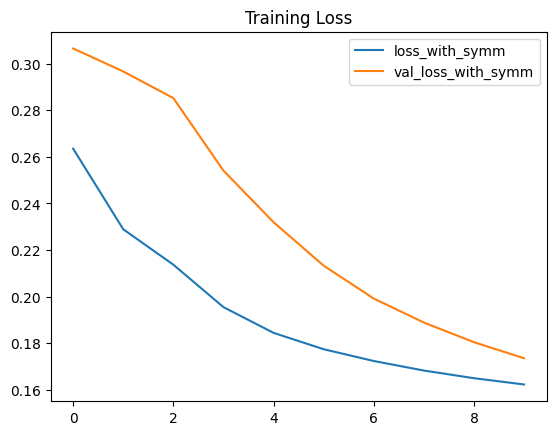

In [15]:
road_train_loss = road_train_loss
road_test_loss = road_test_loss
epochs = range(len(road_train_loss))

plt.plot(epochs,road_train_loss)
plt.plot(epochs,road_test_loss)

plt.title('Training Loss')

plt.legend(["loss_with_symm", "val_loss_with_symm"])

## Method 2

In [16]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
loss = tf.keras.losses.MeanSquaredError()

road_model_with_symm = tf.keras.Sequential([
    
    tf.keras.layers.Dense(3, 'relu'),
    tf.keras.layers.Dense(6,'linear')

])

road_model_with_symm.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

road_history_symm = road_model_with_symm.fit(x=road_symmetrized_x_dataset,
                         y=road_y_dataset,
                         batch_size=1,
                         epochs=30,
                         validation_split=0.3,
                         shuffle=True)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0000e+00 - loss: 0.2466 - val_accuracy: 0.0000e+00 - val_loss: 1.2030
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.2170 - val_accuracy: 0.0000e+00 - val_loss: 1.1958
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.2486 - val_accuracy: 0.0000e+00 - val_loss: 1.1891
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.2893 - val_accuracy: 0.0000e+00 - val_loss: 1.1828
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.2858 - val_accuracy: 0.0000e+00 - val_loss: 1.1763
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.2680 - val_accuracy: 0.0000e+00 - val_loss: 1.1700
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.3800 - val_accuracy: 0.0000e+00 - val_loss: 1.1636
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

Text(0.5, 1.0, 'Training and Validation Loss')

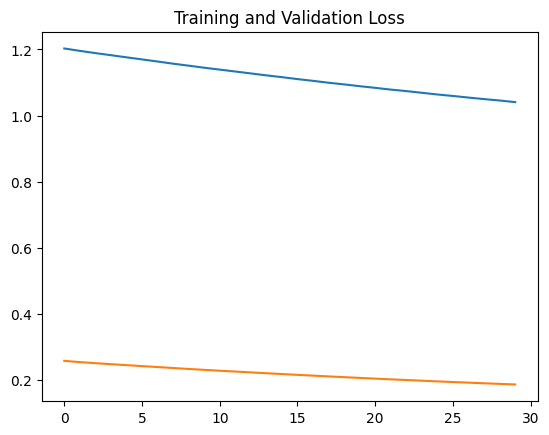

In [17]:
acc = road_history_symm.history['accuracy']
val_acc = road_history_symm.history['val_accuracy']

loss = road_history_symm.history['loss']
val_loss = road_history_symm.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,val_loss)
#plt.plot(epochs,val_acc)

plt.plot(epochs,loss)
#plt.plot(epochs,acc)

plt.title('Training and Validation Loss')


In [18]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
loss = tf.keras.losses.MeanSquaredError()

road_model_without_symm = tf.keras.Sequential([
      
    tf.keras.layers.Dense(42, 'relu'),
    tf.keras.layers.Dense(6,'linear')

])

road_model_without_symm.compile(loss=loss,
              optimizer=optimizer,
              metrics=['accuracy'])

road_history_without_symm = road_model_without_symm.fit(x=road_unsymmetrized_x_dataset,
                         y=road_y_dataset,
                         batch_size=1,
                         epochs=30,
                         validation_split=0.3,
                         shuffle=True)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0000e+00 - loss: 0.3031 - val_accuracy: 0.8571 - val_loss: 0.6951
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.2342 - val_accuracy: 0.8571 - val_loss: 0.6840
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.2362 - val_accuracy: 0.2857 - val_loss: 0.6743
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1352 - val_accuracy: 0.2857 - val_loss: 0.6638
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1471 - val_accuracy: 0.2857 - val_loss: 0.6548
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1332 - val_accuracy: 0.2857 - val_loss: 0.6466
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.1456 - val_accuracy: 0.2857 - val_loss: 0.6388
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.1394 -

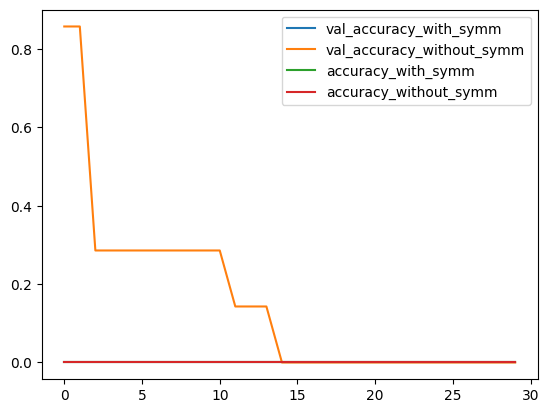

In [19]:
val_accuracy_with_symm = road_history_symm.history['val_accuracy']
val_accuracy_without_symm = road_history_without_symm.history['val_accuracy']

accuracy_with_symm = road_history_symm.history['accuracy']
accuracy_without_symm = road_history_without_symm.history['accuracy']

loss_with_symm = road_history_symm.history['val_loss']
loss_without_symm = road_history_without_symm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,val_accuracy_with_symm)
plt.plot(epochs,val_accuracy_without_symm)

plt.plot(epochs,accuracy_with_symm)
plt.plot(epochs,accuracy_without_symm)

plt.legend(["val_accuracy_with_symm", "val_accuracy_without_symm",
             "accuracy_with_symm", "accuracy_without_symm"])

#plt.title('Mean Sqaured Loss of symmetrized and unsymmetrized data')

Same as before, we have to initiate the circuit with $R_x(x_i)$ where $x_i = \frac{2 \pi}{3} g_i$.

The result of the toy model is one-hot encoded in vector $\mathbb{y} = (y_{0.0},y_{0.2},y_{0.4},y_{0.6},y_{0.8},y_{1.0})$, where $y_n$ indicates the difficulty of the road scenerio in $n$. A $+1$ will be assigned to the correct label and $-1$ to the other 5 entries. For example, $(-1,-1,-1,+1,-1,-1)$ represnts a resulting difficulty of $0.6$.


In [ ]:
def encode_road(road):
    road, difficulty = road
    x = road * (2 * math.pi) / 3

    if difficulty == 0.:
        y = [1,-1,-1,-1,-1,-1]
    
    elif difficulty == 0.2:
        y = [-1,1,-1,-1,-1,-1]

    elif difficulty == 0.4:
        y = [-1,-1,1,-1,-1,-1]

    elif difficulty == 0.6:
        y = [-1,-1,-1,1,-1,-1]

    elif difficulty == 0.8:
        y = [-1,-1,-1,-1,1,-1]

    else:
        y = [-1,-1,-1,-1,-1,1]

    return x, y